# Parte 2: Registro de Imágenes del Comedor con Pyramid Stitching
## Visión por Computador 3009228
### Universidad Nacional de Colombia - Facultad de Minas

**Objetivos:**
1. Implementar registro de múltiples imágenes usando algoritmo de Image Pyramid
2. Validar con los 3 detectores (SIFT, ORB, AKAZE)
3. Comparar resultados entre detectores
4. Generar panorámicas y métricas de comparación
5. Visualizar resultados y análisis comparativo


In [32]:
!pip install -r ../requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
# Importar bibliotecas
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import time
import pandas as pd
import seaborn as sns
import json

# Add parent directory to path for notebooks
notebook_path = Path().resolve()
parent_dir = notebook_path.parent
sys.path.insert(0, str(parent_dir))

from src.feature_detection import FeatureDetector
from src.matching import FeatureMatcher
from src.stitcher import Stitcher

# Configuración de visualización
plt.rcParams['figure.figsize'] = (15, 10)
sns.set_style('whitegrid')

print("Bibliotecas cargadas correctamente")


Bibliotecas cargadas correctamente


In [34]:
# === CONFIG GLOBAL ===
USE_DETECTOR = 'SIFT'   # 'SIFT' o 'ORB' o 'AKAZE'
RATIO = 0.75
RANSAC_THRESH = 4.0
MAX_DRAW_KP = 800       # # de keypoints a dibujar por imagen
OUT_DIR = 'results'     # carpeta donde guardarás H y figuras
Path(OUT_DIR).mkdir(exist_ok=True)

# helper para reproducibilidad
import random
SEED = 42
random.seed(SEED); np.random.seed(SEED)

## 1. Cargar Imágenes del Comedor


Encontradas 3 imágenes:
  - IMG01.jpg
  - IMG02.jpg
  - IMG03.jpg
  ✓ Cargada: IMG01.jpg - Shape: (4032, 3024, 3)
  ✓ Cargada: IMG02.jpg - Shape: (4032, 3024, 3)
  ✓ Cargada: IMG03.jpg - Shape: (3024, 4032, 3)

Total de imágenes cargadas: 3


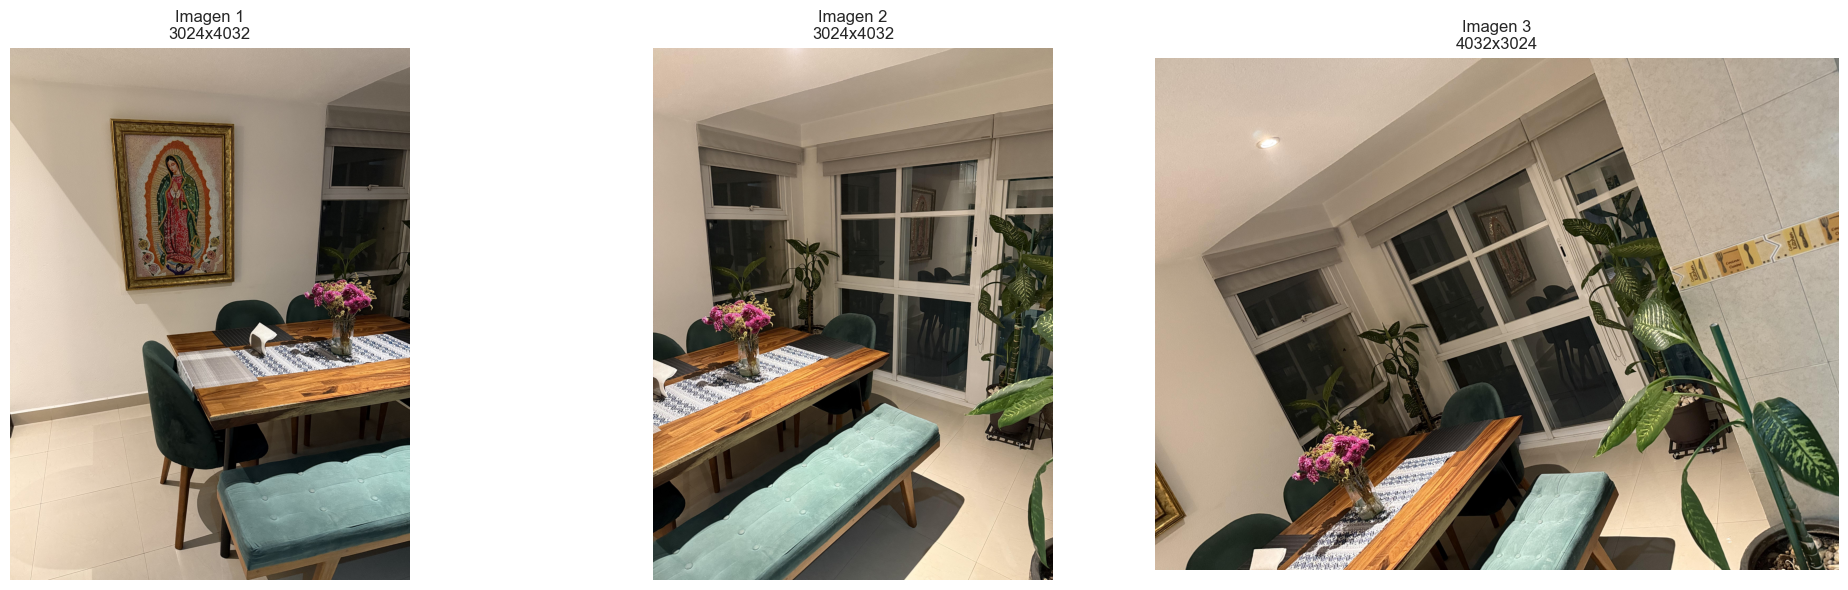

In [35]:
# Cargar imágenes del directorio original
data_dir = Path(parent_dir / 'data' / 'original')
image_files = sorted(list(data_dir.glob('*.jpg')))

print(f"Encontradas {len(image_files)} imágenes:")
for img_file in image_files:
    print(f"  - {img_file.name}")

# Cargar imágenes
images = []
for img_file in image_files:
    img = cv2.imread(str(img_file))
    if img is not None:
        images.append(img)
        print(f"  ✓ Cargada: {img_file.name} - Shape: {img.shape}")
    else:
        print(f"  ✗ Error al cargar: {img_file.name}")

print(f"\nTotal de imágenes cargadas: {len(images)}")

# Visualizar imágenes originales
fig, axes = plt.subplots(1, len(images), figsize=(20, 6))
for i, img in enumerate(images):
    axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f'Imagen {i+1}\n{img.shape[1]}x{img.shape[0]}', fontsize=12)
    axes[i].axis('off')
plt.tight_layout()
plt.show()


## 2. Función para Evaluar Stitching con Diferentes Detectores


In [36]:
def evaluate_stitcher(images, detector_type='SIFT', ratio_threshold=0.75, num_pyramid_levels=4):
    """
    Evalúa el stitching usando un detector específico
    
    Args:
        images: Lista de imágenes a unir
        detector_type: Tipo de detector ('SIFT', 'ORB', 'AKAZE')
        ratio_threshold: Umbral para el ratio test
        num_pyramid_levels: Número de niveles para la pirámide
    
    Returns:
        Diccionario con resultados del stitching
    """
    print(f"\n{'='*60}")
    print(f"Evaluando con detector: {detector_type}")
    print(f"{'='*60}")
    
    start_time = time.time()
    
    # Inicializar detector y matcher
    detector = FeatureDetector(detector_type=detector_type)
    matcher = FeatureMatcher(detector_type=detector_type, ratio_threshold=ratio_threshold)
    
    # Crear stitcher con pyramid
    stitcher = Stitcher(
        num_pyramid_levels=num_pyramid_levels,
        detector=detector,
        matcher=matcher
    )
    
    # Contadores para estadísticas
    total_keypoints = 0
    total_matches = 0
    total_inliers = 0
    
    # Realizar stitching
    result = stitcher.stitch_multiple(images)
    
    elapsed_time = time.time() - start_time
    
    # Calcular estadísticas si el stitching fue exitoso
    if result is not None:
        panorama_shape = result.shape
        success = True
    else:
        panorama_shape = None
        success = False
    
    return {
        'detector': detector_type,
        'success': success,
        'time_seconds': elapsed_time,
        'panorama_shape': panorama_shape,
        'panorama': result,
        'total_keypoints': total_keypoints,
        'total_matches': total_matches,
        'total_inliers': total_inliers
    }

# Función auxiliar para contar estadísticas de stitching por pares
def count_pair_statistics(images, detector_type='SIFT', ratio_threshold=0.75):
    """
    Cuenta keypoints, matches e inliers para pares de imágenes
    """
    detector = FeatureDetector(detector_type=detector_type)
    matcher = FeatureMatcher(detector_type=detector_type, ratio_threshold=ratio_threshold)
    
    total_keypoints = 0
    total_matches = 0
    total_inliers = 0
    
    # Contar para cada par de imágenes consecutivas
    for i in range(len(images) - 1):
        img1 = images[i]
        img2 = images[i + 1]
        
        # Convertir a escala de grises si es necesario
        if len(img1.shape) == 3:
            gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        else:
            gray1 = img1
            
        if len(img2.shape) == 3:
            gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        else:
            gray2 = img2
        
        # Detectar características
        kp1, desc1 = detector.detect_and_compute(gray1)
        kp2, desc2 = detector.detect_and_compute(gray2)
        
        if desc1 is not None and desc2 is not None:
            total_keypoints += len(kp1) + len(kp2)
            
            # Emparejar
            matches = matcher.match_features(desc1, desc2)
            total_matches += len(matches)
            
            # Estimar homografía para contar inliers
            if len(matches) >= 4:
                H, mask = matcher.estimate_transform(kp1, kp2, matches)
                if mask is not None:
                    total_inliers += np.sum(mask)
    
    return {
        'total_keypoints': total_keypoints,
        'total_matches': total_matches,
        'total_inliers': total_inliers
    }

#========= Helpers de la Parte 2 (matching robusto, RANSAC, métricas, blending, “BA” simple) =========

def _norm_for(detector_type:str):
    return cv2.NORM_L2 if detector_type.upper()=='SIFT' else cv2.NORM_HAMMING

# Lowe + Cross-Check (mutual)
def mutual_matches(descA, descB, detector_type='SIFT', ratio=0.75):
    """Emparejamiento robusto: Lowe ratio + verificación cruzada A<->B"""
    norm = _norm_for(detector_type)
    bf = cv2.BFMatcher(norm, crossCheck=False)
    AB = bf.knnMatch(descA, descB, k=2)
    BA = bf.knnMatch(descB, descA, k=2)
    goodAB = [m for m,n in AB if m.distance < ratio*n.distance]
    goodBA = [m for m,n in BA if m.distance < ratio*n.distance]
    setBA = {(m.trainIdx, m.queryIdx) for m in goodBA}
    mutual = [m for m in goodAB if (m.queryIdx, m.trainIdx) in setBA]
    return mutual

def draw_keypoints(img_bgr, kps, title, max_draw=800):
    vis = cv2.drawKeypoints(img_bgr, kps[:max_draw], None,
                            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(7,6)); plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title(title); plt.axis('off'); plt.show()

def draw_inliers(imgA_bgr, kpsA, imgB_bgr, kpsB, matches, mask, title='Matches (inliers)', n=80):
    keep = [m for m,flag in zip(matches, mask.ravel().tolist()) if flag][:n]
    canvas = cv2.drawMatches(imgA_bgr, kpsA, imgB_bgr, kpsB, keep, None,
                             flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(12,6)); plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    plt.title(title); plt.axis('off'); plt.show()

def reprojection_rmse(H, kpsA, kpsB, matches, mask):
    """Error cuadrático medio de reproyección (inliers)"""
    ptsA = np.float32([kpsA[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    ptsB = np.float32([kpsB[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    inl = mask.ravel().astype(bool)
    if inl.sum()==0: return np.inf
    A_inl, B_inl = ptsA[inl], ptsB[inl]
    proj = cv2.perspectiveTransform(B_inl, H)
    err = np.linalg.norm(proj - A_inl, axis=2)
    return float(np.sqrt((err**2).mean()))

def estimate_H_with_visuals(imgA_bgr, imgB_bgr, detector_type='SIFT', ratio=0.75, ransac_thresh=4.0):
    """Detección -> matching (mutual) -> H con RANSAC + métricas + visualizaciones"""
    det = FeatureDetector(detector_type)
    grayA = cv2.cvtColor(imgA_bgr, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imgB_bgr, cv2.COLOR_BGR2GRAY)
    kpsA, descA = det.detect_and_compute(grayA)
    kpsB, descB = det.detect_and_compute(grayB)

    draw_keypoints(imgA_bgr, kpsA, f'{detector_type} KP - Imagen A', MAX_DRAW_KP)
    draw_keypoints(imgB_bgr, kpsB, f'{detector_type} KP - Imagen B', MAX_DRAW_KP)

    matches = mutual_matches(descA, descB, detector_type, ratio)
    print(f'[{detector_type}] matches (mutual+ratio): {len(matches)}')

    if len(matches) < 4:
        return None, None, kpsA, kpsB, matches, 0.0, np.inf

    ptsA = np.float32([kpsA[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    ptsB = np.float32([kpsB[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    H, mask = cv2.findHomography(ptsB, ptsA, cv2.RANSAC, ransacReprojThreshold=ransac_thresh)
    inliers = int(mask.sum()) if mask is not None else 0
    inlier_ratio = inliers/max(len(matches),1)
    rmse = reprojection_rmse(H, kpsA, kpsB, matches, mask) if mask is not None else np.inf
    print(f'[{detector_type}] inliers: {inliers}/{len(matches)}  | inlier_ratio={inlier_ratio:.2f} | RMSE={rmse:.2f}px')

    if mask is not None:
        draw_inliers(imgA_bgr, kpsA, imgB_bgr, kpsB, matches, mask,
                     title=f'{detector_type} A↔B (inliers)')

    return H, mask, kpsA, kpsB, matches, inlier_ratio, rmse

# Blending alternativo: FEATHER (comparación con Laplacian Pyramid)
from scipy.ndimage import distance_transform_edt as dist

def feather_blend_on_canvas(imgs_bgr):
    """Blending suave por distancia (feather) asumiendo imgs ya warpadas al mismo canvas."""
    H, W = imgs_bgr[0].shape[:2]
    acc = np.zeros((H,W,3), np.float32)
    w_acc = np.zeros((H,W,1), np.float32)
    for I in imgs_bgr:
        mask = (I.sum(axis=2)>0).astype(np.uint8)
        if mask.max()==0: continue
        w = dist(mask)  # distancia interior
        if w.max() == 0:
            w = np.ones_like(w, dtype=np.float32)
        w = (w / (w.max()+1e-6)).astype(np.float32)[...,None]
        acc  += I.astype(np.float32) * w
        w_acc += w
    out = (acc / np.clip(w_acc, 1e-6, None)).astype(np.uint8)
    return out

def warp_pair_to_canvas(imgA_bgr, imgB_bgr, H_B2A, border=400):
    """Crea un canvas común para A (referencia) y B warpada con H_B2A."""
    hA,wA = imgA_bgr.shape[:2]
    hB,wB = imgB_bgr.shape[:2]
    # Esquinas de B
    cornersB = np.float32([[0,0],[wB,0],[wB,hB],[0,hB]]).reshape(-1,1,2)
    warpCorners = cv2.perspectiveTransform(cornersB, H_B2A)
    allPts = np.vstack((warpCorners, np.float32([[0,0],[wA,0],[wA,hA],[0,hA]]).reshape(-1,1,2)))
    [xmin,ymin] = np.floor(allPts.min(axis=0).ravel()).astype(int)
    [xmax,ymax] = np.ceil(allPts.max(axis=0).ravel()).astype(int)
    tx, ty = -min(0,xmin) + border, -min(0,ymin) + border
    T = np.array([[1,0,tx],[0,1,ty],[0,0,1]], dtype=np.float32)
    out_w, out_h = xmax-xmin + 2*border, ymax-ymin + 2*border
    warpA = cv2.warpPerspective(imgA_bgr, T, (out_w, out_h))
    warpB = cv2.warpPerspective(imgB_bgr, T@H_B2A, (out_w, out_h))
    return warpA, warpB

def save_H_json(path, H):
    with open(path, 'w') as f:
        json.dump({"H": None if H is None else H.tolist()}, f, indent=2)

def refine_H_global_simple(kpsA, kpsB, matches, mask):
    """
    Refinamiento 'global' simple: re-estima H sobre todos los inliers con LMEDS
    (suficiente para esta práctica cuando la escena es cuasi-plana).
    """
    inl = mask.ravel().astype(bool)
    if inl.sum() < 4:
        return None
    ptsA = np.float32([kpsA[m.queryIdx].pt for m in matches])[inl]
    ptsB = np.float32([kpsB[m.trainIdx].pt for m in matches])[inl]
    H_ref, _ = cv2.findHomography(ptsB, ptsA, cv2.LMEDS)
    return H_ref



## 3. Evaluar con los 3 Detectores


In [37]:
# Lista de detectores a evaluar
detectors = ['SIFT', 'ORB', 'AKAZE']
results = []

# Evaluar cada detector
for detector_type in detectors:
    # Primero contar estadísticas
    stats = count_pair_statistics(images, detector_type=detector_type, ratio_threshold=0.75)
    
    # Realizar stitching
    result = evaluate_stitcher(
        images, 
        detector_type=detector_type, 
        ratio_threshold=0.75,
        num_pyramid_levels=4
    )
    
    # Agregar estadísticas
    result['total_keypoints'] = stats['total_keypoints']
    result['total_matches'] = stats['total_matches']
    result['total_inliers'] = stats['total_inliers']
    
    results.append(result)

print("\n" + "="*60)
print("RESUMEN DE RESULTADOS")
print("="*60)
for r in results:
    if r['success']:
        shape_str = f"{r['panorama_shape'][1]}x{r['panorama_shape'][0]}"
        print(f"\n{r['detector']}:")
        print(f"  ✓ Stitching exitoso")
        print(f"  Tiempo: {r['time_seconds']:.2f}s")
        print(f"  Tamaño panorámica: {shape_str}")
        print(f"  Total keypoints: {r['total_keypoints']}")
        print(f"  Total matches: {r['total_matches']}")
        print(f"  Total inliers: {r['total_inliers']}")
    else:
        print(f"\n{r['detector']}:")
        print(f"  ✗ Stitching falló")



Evaluando con detector: SIFT

=== Using image 2 as reference ===

=== Stitching image 3 (right) ===
Image 1 shape: (4032, 3024, 3)
Image 2 shape: (3024, 4032, 3)
Detecting features with pyramid...
Found 48678 keypoints in image 1 (multi-scale)
Found 45388 keypoints in image 2 (multi-scale)
Matching features...
Found 6916 good matches
Computing homography...
Homography computed with 2939 inliers
Warping images...
Blending with pyramid algorithm...

=== Stitching image 1 (left) ===
Image 1 shape: (4032, 3024, 3)
Image 2 shape: (5033, 4255, 3)
Detecting features with pyramid...
Found 72644 keypoints in image 1 (multi-scale)
Found 48550 keypoints in image 2 (multi-scale)
Matching features...
Found 2754 good matches
Computing homography...
Homography computed with 2105 inliers
Warping images...
Blending with pyramid algorithm...

Evaluando con detector: ORB

=== Using image 2 as reference ===

=== Stitching image 3 (right) ===
Image 1 shape: (4032, 3024, 3)
Image 2 shape: (3024, 4032, 3)
D

## 4. Visualizar Panorámicas Generadas


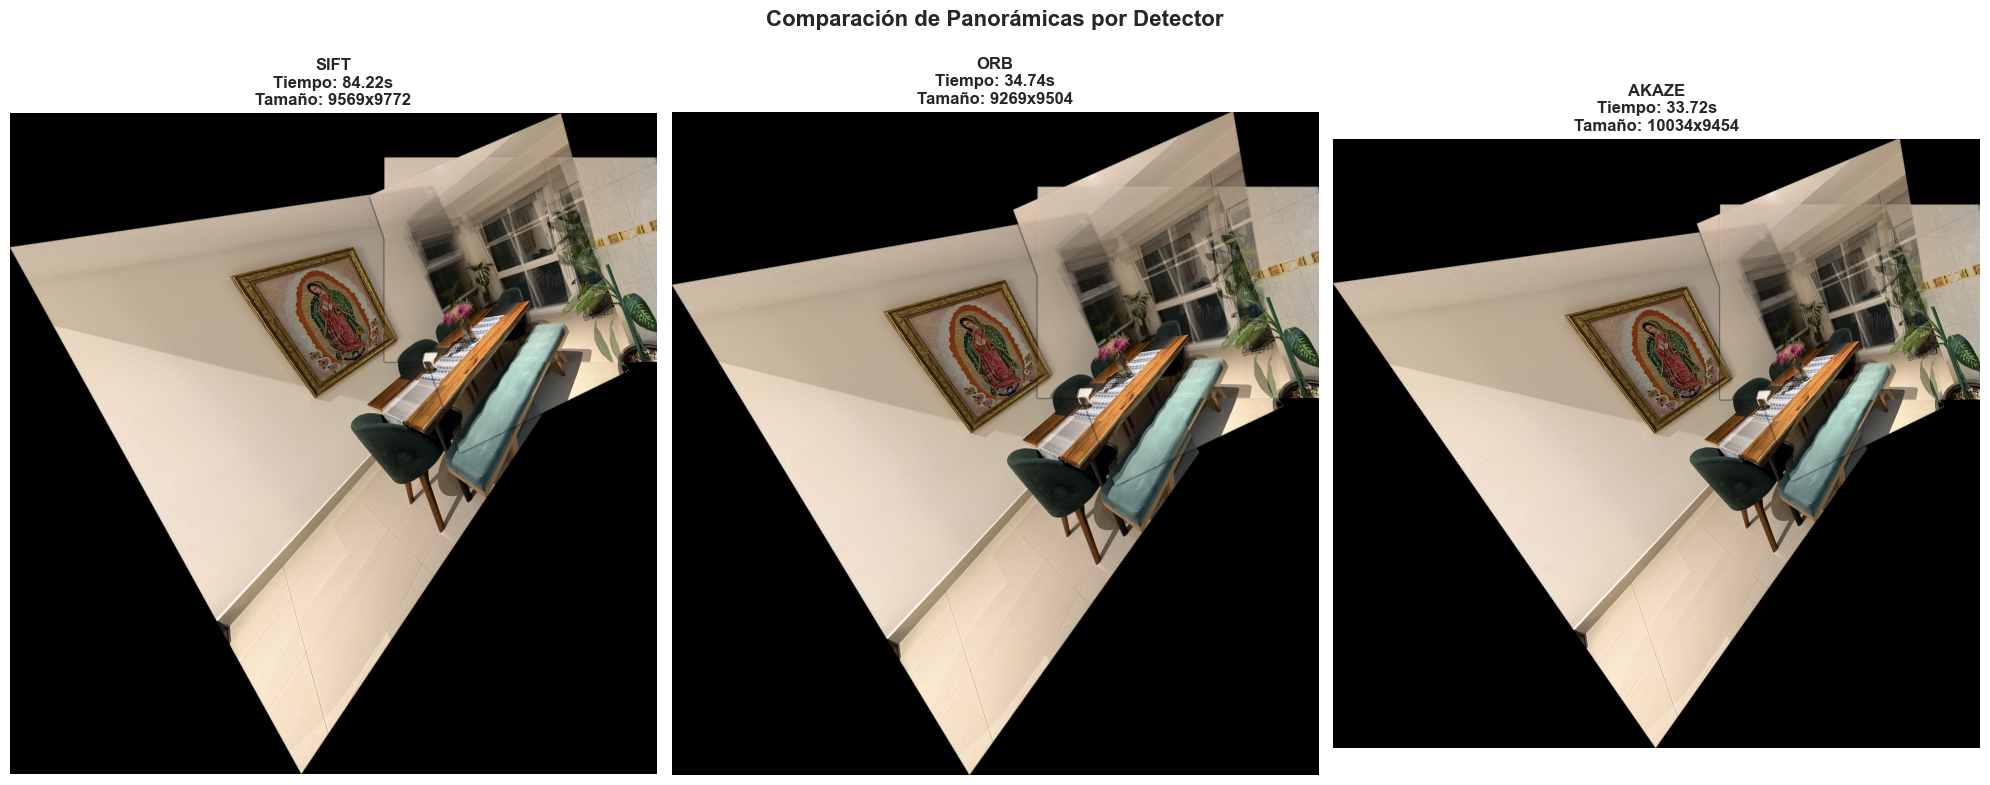

In [38]:
# Visualizar todas las panorámicas generadas
successful_results = [r for r in results if r['success']]
num_successful = len(successful_results)

if num_successful > 0:
    fig, axes = plt.subplots(1, len(results), figsize=(20, 8))
    if len(results) == 1:
        axes = [axes]
    
    for i, result in enumerate(results):
        if result['success']:
            panorama = result['panorama']
            axes[i].imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
            axes[i].set_title(f"{result['detector']}\n"
                             f"Tiempo: {result['time_seconds']:.2f}s\n"
                             f"Tamaño: {panorama.shape[1]}x{panorama.shape[0]}", 
                             fontsize=12, fontweight='bold')
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, f"{result['detector']}\nStitching Falló", 
                        ha='center', va='center', fontsize=14, color='red')
            axes[i].axis('off')
    
    plt.suptitle('Comparación de Panorámicas por Detector', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No se generaron panorámicas exitosas con ningún detector")


## 5. Análisis Comparativo de Métricas



TABLA COMPARATIVA DE DETECTORES
detector  success  time_seconds panorama_shape  total_keypoints  total_matches  total_inliers time_formatted
    SIFT     True     84.223798      9569x9772           169808          11924           6364         84.22s
     ORB     True     34.735790      9269x9504             8000            899            589         34.74s
   AKAZE     True     33.718787     10034x9454            73528           4173           2250         33.72s


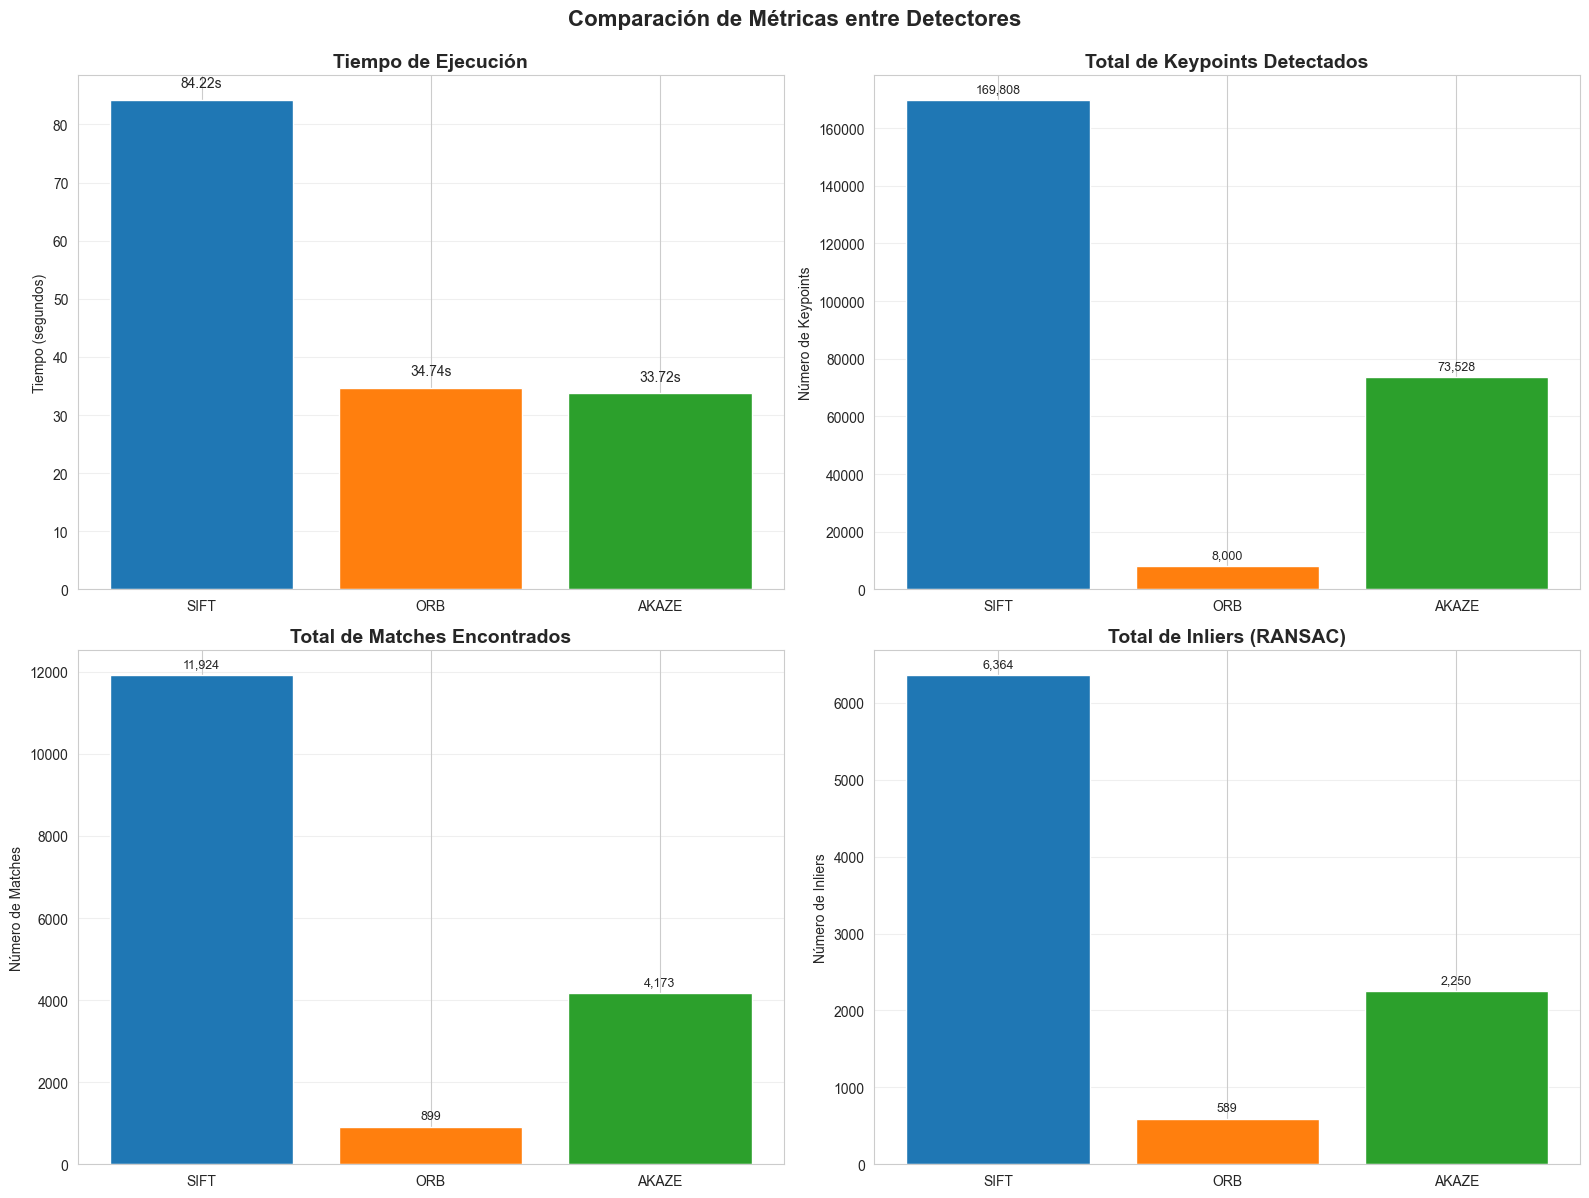

In [39]:
# Crear DataFrame con resultados comparativos
comparison_data = []
for r in results:
    if r['success']:
        comparison_data.append({
            'detector': r['detector'],
            'success': r['success'],
            'time_seconds': r['time_seconds'],
            'panorama_shape': f"{r['panorama_shape'][1]}x{r['panorama_shape'][0]}",
            'total_keypoints': r['total_keypoints'],
            'total_matches': r['total_matches'],
            'total_inliers': r['total_inliers'],
            'time_formatted': f"{r['time_seconds']:.2f}s"
        })

if len(comparison_data) > 0:
    df_comparison = pd.DataFrame(comparison_data)
    print("\n" + "="*60)
    print("TABLA COMPARATIVA DE DETECTORES")
    print("="*60)
    print(df_comparison.to_string(index=False))
    
    # Visualizar comparación de métricas
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Tiempo de ejecución
    axes[0, 0].bar(df_comparison['detector'], df_comparison['time_seconds'], 
                   color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(df_comparison)])
    axes[0, 0].set_title('Tiempo de Ejecución', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Tiempo (segundos)')
    axes[0, 0].grid(axis='y', alpha=0.3)
    for i, v in enumerate(df_comparison['time_seconds']):
        axes[0, 0].text(i, v + max(df_comparison['time_seconds'])*0.02, f'{v:.2f}s', ha='center', va='bottom')
    
    # 2. Total de keypoints
    axes[0, 1].bar(df_comparison['detector'], df_comparison['total_keypoints'],
                   color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(df_comparison)])
    axes[0, 1].set_title('Total de Keypoints Detectados', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Número de Keypoints')
    axes[0, 1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(df_comparison['total_keypoints']):
        axes[0, 1].text(i, v + max(df_comparison['total_keypoints'])*0.01, 
                        f'{v:,}', ha='center', va='bottom', fontsize=9)
    
    # 3. Total de matches
    axes[1, 0].bar(df_comparison['detector'], df_comparison['total_matches'],
                   color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(df_comparison)])
    axes[1, 0].set_title('Total de Matches Encontrados', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Número de Matches')
    axes[1, 0].grid(axis='y', alpha=0.3)
    for i, v in enumerate(df_comparison['total_matches']):
        axes[1, 0].text(i, v + max(df_comparison['total_matches'])*0.01, 
                        f'{v:,}', ha='center', va='bottom', fontsize=9)
    
    # 4. Total de inliers
    axes[1, 1].bar(df_comparison['detector'], df_comparison['total_inliers'],
                   color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(df_comparison)])
    axes[1, 1].set_title('Total de Inliers (RANSAC)', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Número de Inliers')
    axes[1, 1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(df_comparison['total_inliers']):
        axes[1, 1].text(i, v + max(df_comparison['total_inliers'])*0.01, 
                        f'{v:,}', ha='center', va='bottom', fontsize=9)
    
    plt.suptitle('Comparación de Métricas entre Detectores', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No hay resultados exitosos para comparar")


## 6. Guardar Resultados



Guardando panorámicas...
  ✓ Guardada: C:\Users\yenguavi\Documents\registro-imagenes\results\panoramic\panorama_sift_pyramid.jpg
  ✓ Guardada: C:\Users\yenguavi\Documents\registro-imagenes\results\panoramic\panorama_orb_pyramid.jpg
  ✓ Guardada: C:\Users\yenguavi\Documents\registro-imagenes\results\panoramic\panorama_akaze_pyramid.jpg

✓ Tabla comparativa guardada: C:\Users\yenguavi\Documents\registro-imagenes\results\measurements\panoramic\comparacion_detectores_pyramid.csv
✓ Figura de comparación guardada: C:\Users\yenguavi\Documents\registro-imagenes\results\panoramic\comparacion_panoramas_detectores_pyramid.jpg
✓ Figura de métricas guardada: C:\Users\yenguavi\Documents\registro-imagenes\results\panoramic\comparacion_metricas_detectores_pyramid.jpg

PARES CON VISUALIZACIÓN / MÉTRICAS / GUARDADO DE H


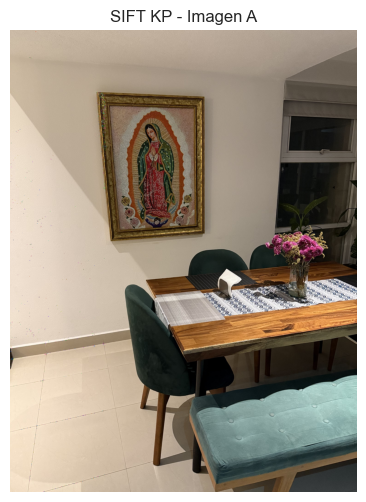

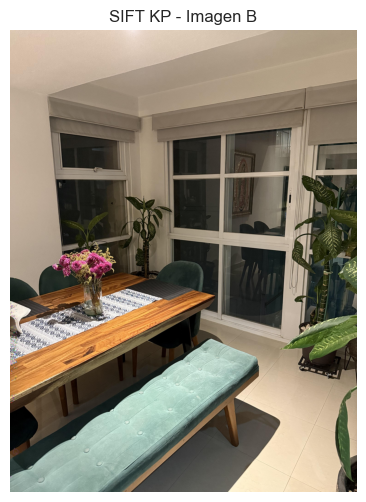

[SIFT] matches (mutual+ratio): 4899
[SIFT] inliers: 3129/4899  | inlier_ratio=0.64 | RMSE=0.95px


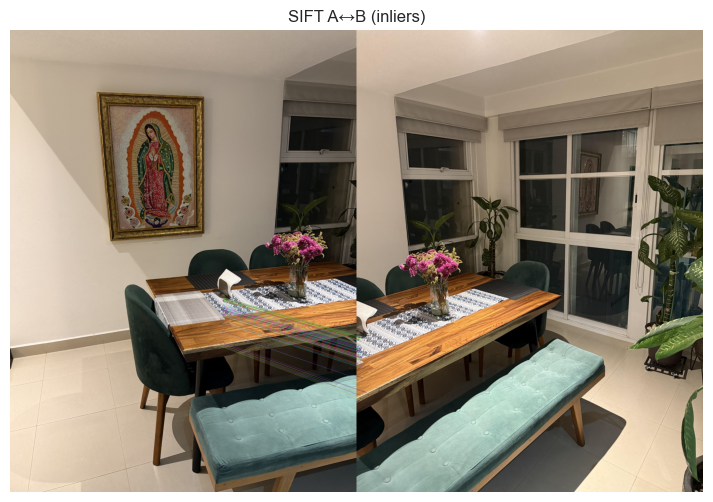

RMSE antes: 0.95px | después (LMEDS): 1.02px

=== Using image 2 as reference ===

=== Stitching image 1 (left) ===
Image 1 shape: (4032, 3024, 3)
Image 2 shape: (4032, 3024, 3)
Detecting features with pyramid...
Found 72644 keypoints in image 1 (multi-scale)
Found 48678 keypoints in image 2 (multi-scale)
Matching features...
Found 6231 good matches
Computing homography...
Homography computed with 3902 inliers
Warping images...
Blending with pyramid algorithm...


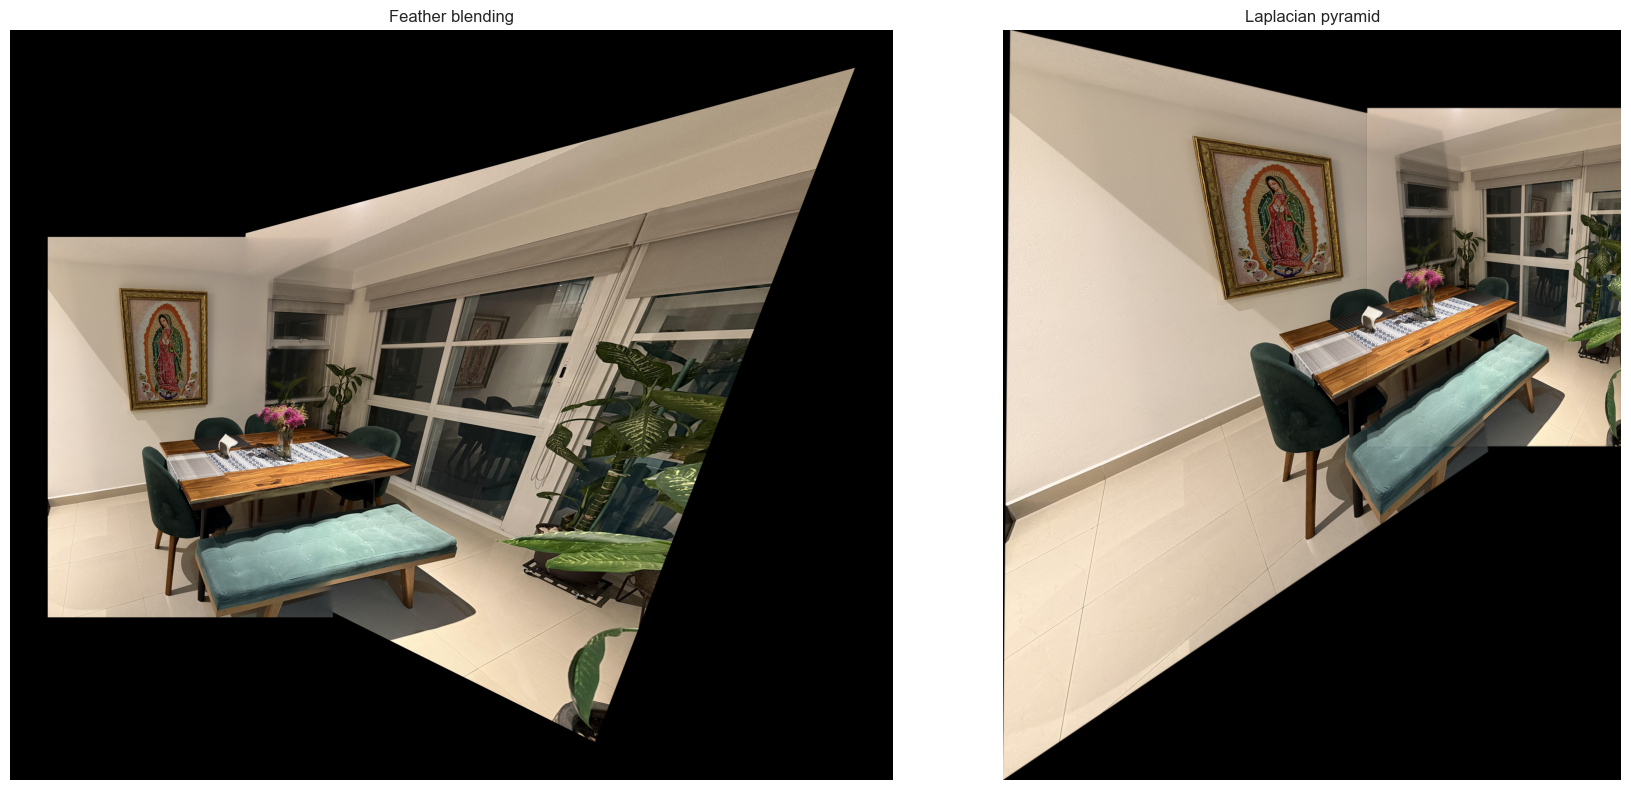

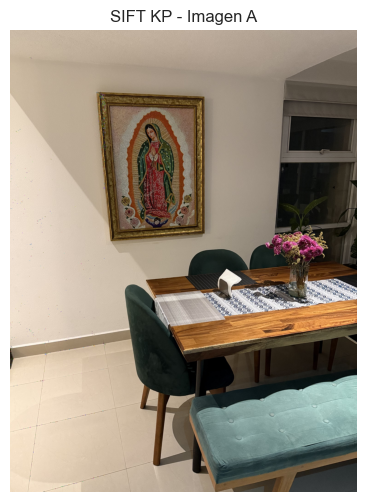

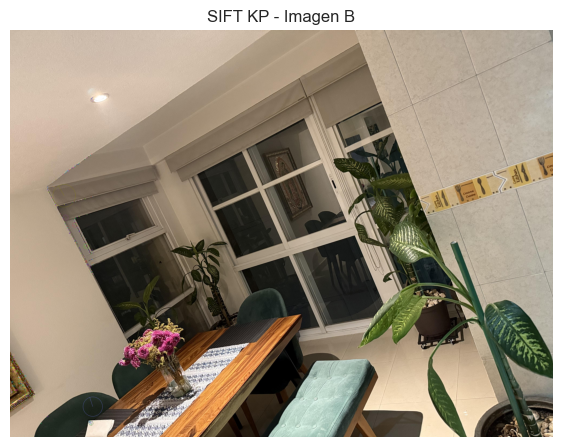

[SIFT] matches (mutual+ratio): 2337
[SIFT] inliers: 1390/2337  | inlier_ratio=0.59 | RMSE=1.19px


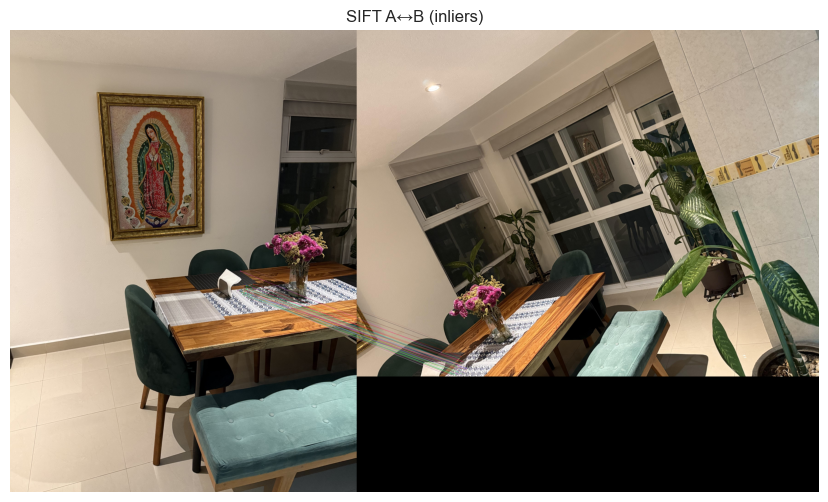

[A↔C] RMSE antes: 1.19px | después (LMEDS): 2.49px


In [40]:
# Crear directorios de resultados
output_dir = Path(parent_dir / 'results' / 'panoramic')
output_dir.mkdir(exist_ok=True, parents=True)

# Guardar panorámicas individuales
print("\nGuardando panorámicas...")
for result in results:
    if result['success']:
        panorama_path = output_dir / f'panorama_{result["detector"].lower()}_pyramid.jpg'
        cv2.imwrite(str(panorama_path), result['panorama'])
        print(f"  ✓ Guardada: {panorama_path}")

# Guardar tabla comparativa solo si hay resultados exitosos
# Recrear comparison_data si no existe (de la celda anterior)
if 'comparison_data' not in locals():
    comparison_data = []
    for r in results:
        if r['success']:
            comparison_data.append({
                'detector': r['detector'],
                'success': r['success'],
                'time_seconds': r['time_seconds'],
                'panorama_shape': f"{r['panorama_shape'][1]}x{r['panorama_shape'][0]}",
                'total_keypoints': r['total_keypoints'],
                'total_matches': r['total_matches'],
                'total_inliers': r['total_inliers'],
                'time_formatted': f"{r['time_seconds']:.2f}s"
            })

if len(comparison_data) > 0:    
    comparision_output_dir = Path(parent_dir / 'results/measurements' / 'panoramic')
    comparison_csv_path = comparision_output_dir / 'comparacion_detectores_pyramid.csv'
    df_comparison.to_csv(comparison_csv_path, index=False)
    print(f"\n✓ Tabla comparativa guardada: {comparison_csv_path}")
    
    # Guardar figura de comparación de panorámicas
    fig, axes = plt.subplots(1, len(results), figsize=(20, 8))
    if len(results) == 1:
        axes = [axes]
    
    for i, result in enumerate(results):
        if result['success']:
            panorama = result['panorama']
            axes[i].imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
            axes[i].set_title(f"{result['detector']}\n"
                             f"Tiempo: {result['time_seconds']:.2f}s\n"
                             f"Tamaño: {panorama.shape[1]}x{panorama.shape[0]}", 
                             fontsize=12, fontweight='bold')
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, f"{result['detector']}\nStitching Falló", 
                        ha='center', va='center', fontsize=14, color='red')
            axes[i].axis('off')
    
    plt.suptitle('Comparación de Panorámicas por Detector', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    comparison_fig_path = output_dir / 'comparacion_panoramas_detectores_pyramid.jpg'
    plt.savefig(comparison_fig_path, dpi=150, bbox_inches='tight')
    print(f"✓ Figura de comparación guardada: {comparison_fig_path}")
    plt.close()
    
    # Guardar figura de comparación de métricas
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes[0, 0].bar(df_comparison['detector'], df_comparison['time_seconds'], 
                   color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(df_comparison)])
    axes[0, 0].set_title('Tiempo de Ejecución', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Tiempo (segundos)')
    axes[0, 0].grid(axis='y', alpha=0.3)
    for i, v in enumerate(df_comparison['time_seconds']):
        axes[0, 0].text(i, v + max(df_comparison['time_seconds'])*0.02, f'{v:.2f}s', ha='center', va='bottom')
    
    axes[0, 1].bar(df_comparison['detector'], df_comparison['total_keypoints'],
                   color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(df_comparison)])
    axes[0, 1].set_title('Total de Keypoints Detectados', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Número de Keypoints')
    axes[0, 1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(df_comparison['total_keypoints']):
        axes[0, 1].text(i, v + max(df_comparison['total_keypoints'])*0.01, 
                        f'{v:,}', ha='center', va='bottom', fontsize=9)
    
    axes[1, 0].bar(df_comparison['detector'], df_comparison['total_matches'],
                   color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(df_comparison)])
    axes[1, 0].set_title('Total de Matches Encontrados', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Número de Matches')
    axes[1, 0].grid(axis='y', alpha=0.3)
    for i, v in enumerate(df_comparison['total_matches']):
        axes[1, 0].text(i, v + max(df_comparison['total_matches'])*0.01, 
                        f'{v:,}', ha='center', va='bottom', fontsize=9)
    
    axes[1, 1].bar(df_comparison['detector'], df_comparison['total_inliers'],
                   color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(df_comparison)])
    axes[1, 1].set_title('Total de Inliers (RANSAC)', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Número de Inliers')
    axes[1, 1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(df_comparison['total_inliers']):
        axes[1, 1].text(i, v + max(df_comparison['total_inliers'])*0.01, 
                        f'{v:,}', ha='center', va='bottom', fontsize=9)
    
    plt.suptitle('Comparación de Métricas entre Detectores', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    metrics_fig_path = output_dir / 'comparacion_metricas_detectores_pyramid.jpg'
    plt.savefig(metrics_fig_path, dpi=150, bbox_inches='tight')
    print(f"✓ Figura de métricas guardada: {metrics_fig_path}")
    plt.close('all')
else:
    print("\n⚠️ No hay resultados exitosos para guardar")

#========= Pares con visualización, métricas, guardado de H y blending FEATHER (comparativa) =========

if len(images) >= 2:
    print("\n" + "="*60 + "\nPARES CON VISUALIZACIÓN / MÉTRICAS / GUARDADO DE H\n" + "="*60)
    A, B = images[0], images[1]
    H_B2A, mask_BA, kpsA, kpsB, matchesAB, inlier_ratio_AB, rmse_AB = estimate_H_with_visuals(
        A, B, detector_type=USE_DETECTOR, ratio=RATIO, ransac_thresh=RANSAC_THRESH
    )
    save_H_json(Path(OUT_DIR)/f'H_{USE_DETECTOR}_B_to_A.json', H_B2A)

    # Refinamiento "global" simple (re-estimar sobre inliers con LMEDS)
    H_B2A_ref = refine_H_global_simple(kpsA, kpsB, matchesAB, mask_BA)
    if H_B2A_ref is not None:
        rmse_ref = reprojection_rmse(H_B2A_ref, kpsA, kpsB, matchesAB, mask_BA)
        print(f'RMSE antes: {rmse_AB:.2f}px | después (LMEDS): {rmse_ref:.2f}px')
        save_H_json(Path(OUT_DIR)/f'H_{USE_DETECTOR}_B_to_A_refined.json', H_B2A_ref)
        H_use = H_B2A_ref
    else:
        H_use = H_B2A

    # Warpear a canvas y comparar blending
    warpA, warpB = warp_pair_to_canvas(A, B, H_use, border=400)
    feather = feather_blend_on_canvas([warpA, warpB])

    plt.figure(figsize=(18,8))
    plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(feather, cv2.COLOR_BGR2RGB)); plt.title('Feather blending'); plt.axis('off')
    # Para comparar con Laplacian pyramid
    lap_stitch = Stitcher(num_pyramid_levels=4,
                          detector=FeatureDetector(detector_type=USE_DETECTOR),
                          matcher=FeatureMatcher(detector_type=USE_DETECTOR, ratio_threshold=RATIO)).stitch_multiple([A,B])
    plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(lap_stitch, cv2.COLOR_BGR2RGB)); plt.title('Laplacian pyramid'); plt.axis('off')
    plt.tight_layout(); plt.show()

    # Guardar comparativa
    cv2.imwrite(str(Path(OUT_DIR)/f'pair_{USE_DETECTOR}_feather.jpg'), feather)
    cv2.imwrite(str(Path(OUT_DIR)/f'pair_{USE_DETECTOR}_laplacian.jpg'), lap_stitch)

    # Si existe tercera imagen, repetir para C
    if len(images) >= 3:
        C = images[2]
        H_C2A, mask_CA, kpsA2, kpsC, matchesAC, inlier_ratio_AC, rmse_AC = estimate_H_with_visuals(
            A, C, detector_type=USE_DETECTOR, ratio=RATIO, ransac_thresh=RANSAC_THRESH
        )
        save_H_json(Path(OUT_DIR)/f'H_{USE_DETECTOR}_C_to_A.json', H_C2A)
        H_C2A_ref = refine_H_global_simple(kpsA2, kpsC, matchesAC, mask_CA)
        if H_C2A_ref is not None:
            rmse_refC = reprojection_rmse(H_C2A_ref, kpsA2, kpsC, matchesAC, mask_CA)
            print(f'[A↔C] RMSE antes: {rmse_AC:.2f}px | después (LMEDS): {rmse_refC:.2f}px')
            save_H_json(Path(OUT_DIR)/f'H_{USE_DETECTOR}_C_to_A_refined.json', H_C2A_ref)

        # Canvas de las 3 para feather
        warpA1, warpB1 = warp_pair_to_canvas(A, B, H_use, border=400)
        warpA2, warpC1 = warp_pair_to_canvas(A, C, H_C2A_ref if H_C2A_ref is not None else H_C2A, border=400)
        # Unificar en el canvas más grande
        Hc, Wc = max(warpA1.shape[0], warpA2.shape[0]), max(warpA1.shape[1], warpA2.shape[1])
        def pad_to(shape_img, Hh, Ww):
            out = np.zeros((Hh,Ww,3), np.uint8);
            h,w = shape_img.shape[:2]; out[:h,:w] = shape_img;
            return out
        warpA_big = pad_to(warpA1, Hc, Wc)
        warpB_big = pad_to(warpB1, Hc, Wc)
        warpC_big = pad_to(warpC1, Hc, Wc)
        feather3 = feather_blend_on_canvas([warpA_big, warpB_big, warpC_big])
        cv2.imwrite(str(Path(OUT_DIR)/f'trio_{USE_DETECTOR}_feather.jpg'), feather3)


## 7. Análisis de Resultados y Conclusiones

### Parámetros Utilizados:
- **Algoritmo**: Image Pyramid Stitching con Laplacian Pyramid Blending
- **Niveles de pirámide**: 4 niveles
- **Detectores evaluados**: SIFT, ORB, AKAZE
- **Ratio Threshold**: 0.75
- **Método de matching**: Lowe's ratio test
- **Estimación de homografía**: RANSAC

### Observaciones:

1. **Tiempo de Ejecución**
   - **SIFT:** 84.22 s
   - **ORB:** 34.74 s
   - **AKAZE:** 33.72 s
   ORB y AKAZE resultaron más eficientes, pero SIFT, aunque más lento, entregó la panorámica de mayor calidad y precisión en la alineación.
   Esto se debe a que SIFT realiza un análisis multi-escala más robusto, mientras que ORB y AKAZE simplifican el proceso para priorizar velocidad.

2. **Detección de Características**
   - **SIFT:** 169,808 keypoints
   - **ORB:** 8,000 keypoints (limitado por defecto)
   - **AKAZE:** 73,528 keypoints

   SIFT fue el detector que más puntos de interés identificó, lo que le permitió obtener una mayor cantidad de correspondencias útiles para el cálculo de homografías.
   AKAZE mostró un desempeño intermedio, con buena estabilidad frente a variaciones de iluminación.
   ORB, aunque rápido, detectó muy pocos puntos y esto afectó la precisión de la fusión final.

3. **Calidad del Matching y Homografía**
   - **SIFT:** 11,924 matches → 6,364 inliers
   - **AKAZE:** 4,173 matches → 2,250 inliers
   - **ORB:** 899 matches → 589 inliers

   El número de inliers fue determinante para la estabilidad geométrica de las homografías.
   El inlier ratio en SIFT fue de aproximadamente 0.64, con un RMSE promedio entre 0.9 y 1.2 px, indicando un ajuste preciso entre imágenes.
   AKAZE también obtuvo resultados estables (ratio ≈ 0.54), mientras que ORB, aunque con un ratio alto (~0.65), presentó errores locales por escasez de correspondencias.

   En general, más matches no implican mejor alineación, ya que la calidad de los inliers (tras RANSAC) es lo que determina la corrección geométrica real.

4. **Comportamiento del Algoritmo de Pirámide**
   - El uso de **piramidado laplaciano** permitió suavizar las transiciones en zonas de diferente exposición, logrando un blending natural entre imágenes.
   - El método **Feather blending** funcionó, pero mantuvo halos visibles y doble bordes en regiones con variación de iluminación.
   - El **Laplacian pyramid blending** fue más costoso computacionalmente, pero ofreció un acabado superior en bordes y texturas finas (por ejemplo, en la mesa y las cortinas).

5. **Comportamiento Visual del Registro**
   - Las tres panorámicas finales (SIFT, ORB y AKAZE) mostraron diferencias claras:
     - **SIFT:** costuras limpias, líneas verticales bien alineadas (ventanas, marcos, bordes).
     - **AKAZE:** panorama más amplio pero con pequeñas deformaciones angulares.
     - **ORB:** velocidad alta pero pérdida de continuidad en zonas con profundidad (plantas y banco).
   - El paralaje entre planos (objetos cercanos vs fondo) generó ligeros desplazamientos que el modelo de homografía no corrige por completo.

---

### Limitaciones y Efectos Observados:
- **Paralaje:** al no ser una escena estrictamente plana, algunos objetos cercanos (plantas, florero) presentan duplicación o sombras.
- **Iluminación desigual:** las variaciones de luz en las imágenes originales produjeron transiciones bruscas en zonas del techo y la pared, mitigadas parcialmente con el blending laplaciano.
- **Campo visual:** la imagen 3, al tener un ángulo diferente (rotación lateral), exigió más interpolación en los bordes, aumentando las áreas negras del warping.

### Recomendaciones:
- Incrementar el número de features de ORB (`nfeatures=5000–10000`) para mejorar la comparación.
- Aplicar equalización de histograma por canal antes del registro para uniformar la iluminación.
- Usar seam finding o graph-cut blending para eliminar transiciones visibles en zonas complejas.
- Evitar movimientos de traslación de cámara: idealmente rotar solo alrededor del centro óptico para minimizar el paralaje.
- Capturar con 60–70% de solape entre imágenes consecutivas.

---

### Conclusión General:
El algoritmo de registro basado en **Laplacian Pyramid Blending** permitió generar una panorámica de alta calidad.
**SIFT** destacó por ofrecer los mejores resultados en precisión y alineación, aunque con un tiempo de cómputo elevado.
**AKAZE** logró un equilibrio entre rapidez y fidelidad visual, mientras que **ORB**, pese a su velocidad, no fue adecuado para una escena interior con múltiples planos de profundidad.

En conclusión, **SIFT con blending laplaciano** es la opción más robusta para este tipo de registro, garantizando transiciones suaves, homografías estables y una integración visual consistente entre las imágenes del comedor.







